In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from datetime import date
from datetime import timedelta
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = 16, 10

In [2]:
base_path = 'csse_covid_19_data/csse_covid_19_daily_reports/'

#start = date.fromisoformat('2020-02-29')
start = date.fromisoformat('2020-03-22')  # prior to 3/22 the format is different and province/state has a mix of counties, and states, etc.
end = date.today()

df_all = pd.DataFrame(columns=['FIPS', 'Admin2', 'Province_State', 'Country_Region', 'Last_Update',
                              'Lat', 'Long_', 'Confirmed', 'Deaths', 'Recovered', 'Active', 'Combined_Key'])

def rename_column_if_exists(df, old_col_name, new_col_name):
    if old_col_name in df.columns:
        df.rename(columns = {old_col_name: new_col_name}, inplace=True)
        
def str_join(df, sep, *cols):
    from functools import reduce
    return reduce(lambda x, y: x.astype(str).str.cat(y.astype(str), sep=sep), 
                    [df[col] for col in cols])

def create_combined_key_if_missing(df):
    if not 'Combined_Key' in df.columns:
        df.insert(len(df.columns), 'Combined_Key', np.NaN)
    df_missing = df['Combined_Key'].isna()
    df.loc[df_missing,'Combined_Key'] = df.loc[df_missing,:].Province_State.astype(str).str.cat(df.loc[df_missing,:].Country_Region.astype(str), sep=', ', na_rep='')
    
d = end - start
for dayindex in range(0,d.days+1):
    day = start + timedelta(days=dayindex)
    filename = '{:%m-%d-%Y}'.format(day)
    #print(base_path + filename + '.csv')
    try:
        df_input = pd.read_csv(base_path + filename + '.csv')
    except FileNotFoundError as e:
        print('FileNotFoundError - {}'.format(base_path + filename + '.csv'))
        continue
    rename_column_if_exists(df_input, 'Province/State', 'Province_State')
    rename_column_if_exists(df_input, 'Country/Region', 'Country_Region')
    rename_column_if_exists(df_input, 'Last Update', 'Last_Update')
    rename_column_if_exists(df_input, 'Latitude', 'Lat')
    rename_column_if_exists(df_input, 'Longitude', 'Long_')
    create_combined_key_if_missing(df_input)
    df_all = df_all.append(df_input)
    
df_all['Last_Update'] = pd.to_datetime(df_all.Last_Update)
    
df_all.loc[df_all['Province_State']=='California',:]


#df_raw = pd.read_csv('csse_covid_19_data/csse_covid_19_daily_reports/03-30-2020.csv')
#df_raw.head(30)

,FIPS,Admin2,Province_State,Country_Region,Last_Update,Lat,Long_,Confirmed,Deaths,Recovered,Active,Combined_Key
97,6037.0,Los Angeles,California,US,2020-03-22 23:45:00,34.308284,-118.228241,407,5,0,0,"Los Angeles, California, US"
98,6085.0,Santa Clara,California,US,2020-03-22 23:45:00,37.231049,-121.697046,263,8,0,0,"Santa Clara, California, US"
99,6073.0,San Diego,California,US,2020-03-22 23:45:00,33.034846,-116.736533,155,0,0,0,"San Diego, California, US"
100,6081.0,San Mateo,California,US,2020-03-22 23:45:00,37.422881,-122.327555,117,1,0,0,"San Mateo, California, US"
101,6075.0,San Francisco,California,US,2020-03-22 23:45:00,37.752151,-122.438567,108,0,0,0,"San Francisco, California, US"
...,...,...,...,...,...,...,...,...,...,...,...,...
1962,6109.0,Tuolumne,California,US,2020-04-01 21:58:49,38.026440,-119.952509,2,0,0,0,"Tuolumne, California, US"
1978,NaN,Unassigned,California,US,2020-04-01 21:58:49,0.000000,0.000000,0,1,0,0,"Unassigned, California, US"
2036,6111.0,Ventura,California,US,2020-04-01 21:58:49,34.444657,-119.091061,149,5,0,0,"Ventura, California, US"
2213,6113.0,Yolo,California,US,2020-04-01 21:58:49,38.682789,-121.901829,25,1,0,0,"Yolo, California, US"


In [3]:
# Clean it up -- drop unneeded columns and set date as the index
df = df_all.drop(labels=['FIPS', 'Lat', 'Long_'], axis=1)
df = df.melt(id_vars=['Admin2', 'Province_State', 'Country_Region', 'Combined_Key', 'Last_Update'],
            var_name='Metric',
            value_name='Value')
df = df.set_index('Last_Update')
df.head()

,Admin2,Province_State,Country_Region,Combined_Key,Metric,Value
Last_Update,,,,,,
2020-03-22 23:45:00,New York City,New York,US,"New York City, New York, US",Confirmed,9654
2020-03-22 23:45:00,Nassau,New York,US,"Nassau, New York, US",Confirmed,1900
2020-03-22 23:45:00,Westchester,New York,US,"Westchester, New York, US",Confirmed,1873
2020-03-22 23:45:00,Suffolk,New York,US,"Suffolk, New York, US",Confirmed,1034
2020-03-22 23:45:00,Rockland,New York,US,"Rockland, New York, US",Confirmed,455


In [4]:
# Examples of dealing with the data in this format

# Just the death information for Santa Clara County
df.loc[(df.Admin2 == 'Santa Clara') & (df.Metric == 'Deaths')]

# Just Confirmed Cases for Canadian Provinces
df.loc[(df.Metric == 'Confirmed') & (df.Country_Region == 'Canada'), ['Province_State', 'Value']]

# Get the above (confirmed for Canadian Provinces) ready to graph (wide format with column labels being location)
(df.loc[(df.Metric == 'Confirmed') & (df.Country_Region == 'Canada'), ['Province_State', 'Value']]
     .reset_index()     # make the index a column for now
     .pivot_table(index='Last_Update', columns='Province_State', values='Value', aggfunc=np.sum) #pivot() doesn't work because of duplicate indices
)

Province_State,Alberta,British Columbia,Diamond Princess,Grand Princess,Manitoba,New Brunswick,Newfoundland and Labrador,Northwest Territories,Nova Scotia,Ontario,Prince Edward Island,Quebec,Recovered,Saskatchewan,Yukon
Last_Update,,,,,,,,,,,,,,,
2020-03-22 23:48:00,259.0,424.0,0.0,13.0,20.0,17.0,9.0,1.0,28.0,425.0,3.0,219.0,NaN,52.0,NaN
2020-03-23 23:23:10,301.0,472.0,0.0,13.0,20.0,17.0,24.0,NaN,41.0,503.0,3.0,628.0,NaN,66.0,NaN
2020-03-24 23:41:36,359.0,617.0,0.0,13.0,21.0,18.0,35.0,NaN,51.0,588.0,3.0,1013.0,0.0,72.0,NaN
2020-03-25 23:37:36,358.0,617.0,0.0,13.0,35.0,18.0,35.0,NaN,68.0,688.0,5.0,1342.0,0.0,72.0,NaN
2020-03-26 23:53:11,486.0,725.0,0.0,13.0,36.0,33.0,82.0,1.0,73.0,858.0,5.0,1632.0,0.0,95.0,3.0
2020-03-27 23:27:32,542.0,725.0,0.0,13.0,39.0,45.0,102.0,1.0,90.0,994.0,9.0,2024.0,0.0,95.0,3.0
2020-03-28 23:10:51,542.0,884.0,0.0,13.0,64.0,51.0,120.0,1.0,110.0,1144.0,11.0,2498.0,0.0,134.0,4.0
2020-03-29 23:13:52,621.0,884.0,0.0,13.0,72.0,66.0,135.0,1.0,122.0,1355.0,11.0,2840.0,0.0,156.0,4.0
2020-03-30 22:58:41,661.0,970.0,0.0,13.0,96.0,68.0,148.0,1.0,127.0,1706.0,18.0,3430.0,0.0,156.0,4.0


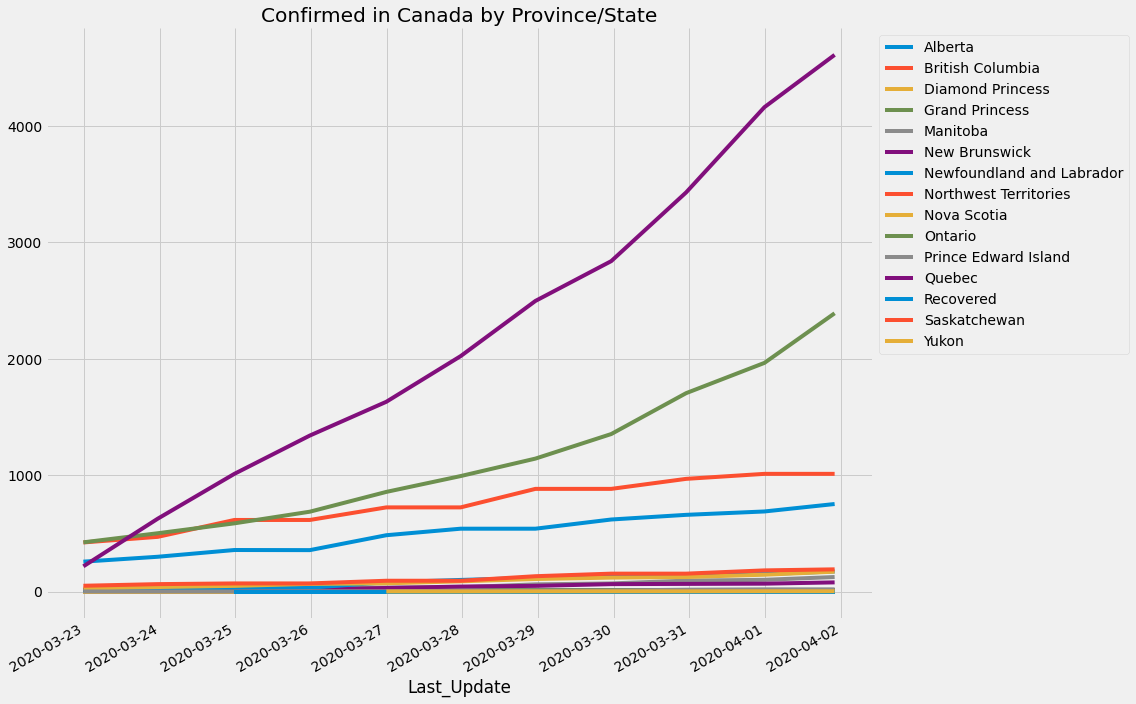

In [5]:
metric = 'Confirmed'
location = 'Canada'
(df.loc[(df.Metric == metric) & (df.Country_Region == location), ['Province_State', 'Value']]
     .reset_index()     # make the index a column for now
     .pivot_table(index='Last_Update', columns='Province_State', values='Value', aggfunc=np.sum)
     .loc['2020-03':,:]
).plot()
plt.legend(bbox_to_anchor=(1, 1))
plt.title('{} in {} by Province/State'.format(metric, location))
plt.tight_layout()
sns.despine()
plt.show()

## Alternative one -- just use Combined_Key

In [6]:
piv1 = df.pivot_table(index=df.index, columns=['Metric','Combined_Key'], values='Value', aggfunc=np.sum)
piv1.tail() # Note the MultiIndex for the columns (Metric, Combined_Key)

Metric                Active                            \
Combined_Key        ,,Belize ,,MS Zaandam ,,Mauritania   
Last_Update                                              
2020-04-01 14:00:34      NaN          NaN          NaN   
2020-04-01 21:58:34      3.0          7.0          3.0   
2020-04-01 21:58:49      NaN          NaN          NaN   
2020-04-01 22:04:44      NaN          NaN          NaN   
2020-04-01 22:04:58      NaN          NaN          NaN   

Metric                                            \
Combined_Key        ,Northern Mariana Islands,US   
Last_Update                                        
2020-04-01 14:00:34                          NaN   
2020-04-01 21:58:34                          NaN   
2020-04-01 21:58:49                          0.0   
2020-04-01 22:04:44                          NaN   
2020-04-01 22:04:58                          NaN   

Metric                                                                \
Combined_Key        ,Northwest Territories,Canada ,Virgin Islands,US   
Last_Update                                                            
2020-04-01 14:00:34                           NaN                NaN   
2020-04-01 21:58:34                           NaN                NaN   
2020-04-01 21:58:49                           NaN                0.0   
2020-04-01 22:04:44                           0.0                NaN   
2020-04-01 22:04:58                           NaN                NaN   

Metric                                                           \
Combined_Key        ,Yukon,Canada Abbeville, South Carolina, US   
Last_Update                                                       
2020-04-01 14:00:34           NaN                           NaN   
2020-04-01 21:58:34           NaN                           NaN   
2020-04-01 21:58:49           NaN                           0.0   
2020-04-01 22:04:44           0.0                           NaN   
2020-04-01 22:04:58           NaN                           NaN   

Metric                                                            ...  \
Combined_Key        Acadia, Louisiana, US Accomack, Virginia, US  ...   
Last_Update                                                       ...   
2020-04-01 14:00:34                   NaN                    NaN  ...   
2020-04-01 21:58:34                   NaN                    NaN  ...   
2020-04-01 21:58:49                   0.0                    0.0  ...   
2020-04-01 22:04:44                   NaN                    NaN  ...   
2020-04-01 22:04:58                   NaN                    NaN  ...   

Metric                              Recovered                    \
Combined_Key        Yukon-Koyukuk, Alaska, US Yuma, Arizona, US   
Last_Update                                                       
2020-04-01 14:00:34                       NaN               NaN   
2020-04-01 21:58:34                       NaN               NaN   
2020-04-01 21:58:49                       NaN               0.0   
2020-04-01 22:04:44                       NaN               NaN   
2020-04-01 22:04:58                       NaN               NaN   

Metric                                                                         \
Combined_Key        Yuma, Colorado, US Yunnan, China Zambia Zapata, Texas, US   
Last_Update                                                                     
2020-04-01 14:00:34                NaN           NaN    NaN               NaN   
2020-04-01 21:58:34                NaN           NaN    0.0               NaN   
2020-04-01 21:58:49                0.0           NaN    NaN               NaN   
2020-04-01 22:04:44                NaN           NaN    NaN               NaN   
2020-04-01 22:04:58                NaN           NaN    NaN               NaN   

Metric                                                 \
Combined_Key        Zavala, Texas, US Zhejiang, China   
Last_Update                                             
2020-04-01 14:00:34               NaN             NaN   
2020-

In [7]:
# look at just the deaths (Metric == 'Deaths') aka the top level of the MultiIndex is 'Deaths'
idx = pd.IndexSlice
piv1.loc[:,idx['Deaths']]

Combined_Key,",,Belize",",,MS Zaandam",",,Mauritania",",Northern Mariana Islands,US",",Northwest Territories,Canada",",Virgin Islands,US",",Yukon,Canada","Abbeville, South Carolina, US","Acadia, Louisiana, US","Accomack, Virginia, US",...,"Yukon-Koyukuk, Alaska, US","Yuma, Arizona, US","Yuma, Colorado, US","Yunnan, China",Zambia,"Zapata, Texas, US","Zavala, Texas, US","Zhejiang, China","Ziebach, South Dakota, US",Zimbabwe
Last_Update,,,,,,,,,,,,,,,,,,,,,
2020-02-23 11:19:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-23 11:19:02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-08 05:19:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-08 05:19:01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-08 05:31:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-04-01 14:00:34,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-04-01 21:58:34,0.0,2.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,1.0
2020-04-01 21:58:49,NaN,NaN,NaN,1.0,NaN,0.0,NaN,0.0,1.0,0.0,...,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
# Look at just deaths in California
# (must use columns.map() because you can't use .str.endswith on a MultiIndex)
piv1.loc[:,idx['Deaths', piv1.columns.map(lambda x: x[1].endswith('California, US'))]]

Metric                               Deaths                         \
Combined_Key        Alameda, California, US Alpine, California, US   
Last_Update                                                          
2020-02-23 11:19:00                     NaN                    NaN   
2020-02-23 11:19:02                     NaN                    NaN   
2020-03-08 05:19:00                     NaN                    NaN   
2020-03-08 05:19:01                     NaN                    NaN   
2020-03-08 05:31:00                     NaN                    NaN   
...                                     ...                    ...   
2020-04-01 14:00:34                     NaN                    NaN   
2020-04-01 21:58:34                     NaN                    NaN   
2020-04-01 21:58:49                     7.0                    0.0   
2020-04-01 22:04:44                     NaN                    NaN   
2020-04-01 22:04:58                     NaN                    NaN   

Metric                                                            \
Combined_Key        Amador, California, US Butte, California, US   
Last_Update                                                        
2020-02-23 11:19:00                    NaN                   NaN   
2020-02-23 11:19:02                    NaN                   NaN   
2020-03-08 05:19:00                    NaN                   NaN   
2020-03-08 05:19:01                    NaN                   NaN   
2020-03-08 05:31:00                    NaN                   NaN   
...                                    ...                   ...   
2020-04-01 14:00:34                    NaN                   NaN   
2020-04-01 21:58:34                    NaN                   NaN   
2020-04-01 21:58:49                    0.0                   0.0   
2020-04-01 22:04:44                    NaN                   NaN   
2020-04-01 22:04:58                    NaN                   NaN   

Metric                                                                \
Combined_Key        Calaveras, California, US Colusa, California, US   
Last_Update                                                            
2020-02-23 11:19:00                       NaN                    NaN   
2020-02-23 11:19:02                       NaN                    NaN   
2020-03-08 05:19:00                       NaN                    NaN   
2020-03-08 05:19:01                       NaN                    NaN   
2020-03-08 05:31:00                       NaN                    NaN   
...                                       ...                    ...   
2020-04-01 14:00:34                       NaN                    NaN   
2020-04-01 21:58:34                       NaN                    NaN   
2020-04-01 21:58:49                       0.0                    0.0   
2020-04-01 22:04:44                       NaN                    NaN   
2020-04-01 22:04:58                       NaN                    NaN   

Metric                                                                      \
Combined_Key        Contra Costa, California, US Del Norte, California, US   
Last_Update                                                                  
2020-02-23 11:19:00                          NaN                       NaN   
2020-02-23 11:19:02                          NaN                       NaN   
2020-03-08 05:19:00                          NaN                       NaN   
2020-03-08 05:19:01                          NaN                       NaN   
2020-03-08 05:31:00                          NaN                       NaN   
...                                          ...                       ...   
2020-04-01 14:00:34                          NaN                       NaN   
2020-04-01 21:58:34                          NaN                       NaN   
2020-04-01 21:58:49                          3.0                       NaN   
2020-04-01 22:04:44                          NaN                       NaN   
2020-04-01 22:04:58                        

## Alternative Two - Use Country, State, Admin2 fields

In [9]:
piv2 = df.pivot_table(index=df.index, columns=['Metric', 'Country_Region', 'Province_State', 'Admin2'], values='Value', aggfunc=np.sum)
piv2.tail()

Metric               Active                                             \
Country_Region           US                                              
Province_State      Alabama                                              
Admin2              Autauga Baldwin Barbour Bibb Blount Bullock Butler   
Last_Update                                                              
2020-03-28 23:05:37     0.0     0.0     0.0  0.0    0.0     0.0    0.0   
2020-03-29 23:08:25     0.0     0.0     0.0  0.0    0.0     0.0    0.0   
2020-03-30 22:52:45     0.0     0.0     0.0  0.0    0.0     0.0    0.0   
2020-03-31 23:43:56     0.0     0.0     NaN  0.0    0.0     0.0    0.0   
2020-04-01 21:58:49     0.0     0.0     NaN  0.0    0.0     0.0    0.0   

Metric                                         ... Recovered              \
Country_Region                                 ...        US               
Province_State                                 ...   Wyoming               
Admin2              Calhoun Chambers Cherokee  ...  Niobrara Park Platte   
Last_Update                                    ...                         
2020-03-28 23:05:37     0.0      0.0      0.0  ...       0.0  0.0    0.0   
2020-03-29 23:08:25     0.0      0.0      0.0  ...       0.0  0.0    0.0   
2020-03-30 22:52:45     0.0      0.0      0.0  ...       0.0  0.0    0.0   
2020-03-31 23:43:56     0.0      0.0      0.0  ...       NaN  0.0    NaN   
2020-04-01 21:58:49     0.0      0.0      0.0  ...       NaN  0.0    NaN   

Metric                                                                        
Country_Region                                                                
Province_State                                                                
Admin2              Sheridan Sublette Sweetwater Teton Uinta Washakie Weston  
Last_Update                                                                   
2020-03-28 23:05:37      0.0      0.0        0.0   0.0   0.0      0.0    0.0  
2020-03-29 23:08:25      0.0      0.0        0.0   0.0   0.0      0.0    0.0  
2020-03-30 22:52:45      0.0      0.0        0.0   0.0   0.0      0.0    0.0  
2020-03-31 23:43:56      0.0      0.0        0.0   0.0   NaN      0.0    NaN  
2020-04-01 21:58:49      0.0      0.0        0.0   0.0   NaN      0.0    NaN  

[5 rows x 12800 columns]

In [13]:
# look at just the deaths (Metric == 'Deaths') aka the top level of the MultiIndex is 'Deaths' for California
idx = pd.IndexSlice
# eliminate all the columns that are all zero and all the rows that are all zero
test = (piv2.loc[:,idx['Deaths',:,'California']]
           .loc[:,lambda df: ]
       
       )


In [12]:
def label_lines(df, ax):
    '''Labels lines in a chart assuming that some lines will be different lengths than others'''
    for label, series in df.items():
        prev_x = series.index[0]
        prev_data = series.iloc[0]
        for index, data in series.items():
            if pd.isnull(data):
                break
            prev_x = index
            prev_data = data
        ax.annotate(label, (prev_x, prev_data),
                            xytext=(10,0), 
                            textcoords='offset pixels',
                            family='sans-serif', fontsize=14, color='darkslategrey')

        
ax = (piv2.loc[:,idx['Deaths',:,'California']]
      .drop(piv2.columns[~(piv2==0).all(axis=1)])
     ).plot(legend=False)
label_lines(piv2, ax)
plt.title('Deaths in California by Location')
plt.tight_layout()
sns.despine()
plt.show()

IndexError: boolean index did not match indexed array along dimension 0; dimension is 12800 but corresponding boolean dimension is 11